# SPINN organize

In [ ]:
from setproctitle import setproctitle
setproctitle("PINN/SPINN")

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

import pyvista as pv
# pv.start_xvfb()
pv.global_theme.trame.server_proxy_enabled = True
pv.set_jupyter_backend('static')

import numpy as np

## Generation of bottom boundary data

### Low Lou

In [ ]:
import numpy as np
from cmspinn.prepare_lowlou import PrepareLowLou

base_path = os.path.expanduser('~/workspace/_data')

creater = PrepareLowLou(base_path=base_path,
                        bounds=[-1, 1, -1, 1, 0, 2], Nx=256, Ny=256, Nz=256, 
                        n=1, m=1, l=0.3, Phi=np.pi/3, 
                        abs=True)

b_bottom_path = os.path.join(creater.lowlou_path, 'b_bottom.npy')
creater.cal_and_save_lowlou()
creater.plot_and_save_lowlou_bottom(plot=False)

Saved /userhome/jeon_mg/workspace/_data/lowlou_256_256_256/b.vtk
Saved /userhome/jeon_mg/workspace/_data/lowlou_256_256_256/b_bottom/b_bottom.npy


### HMI

In [ ]:
from cmspinn.prepare_hmi import PrepareHMI

base_path = os.path.expanduser('~/workspace/_data/NOAA12673/b_bottom/')
hmi_path = '/mnt/obsdata/sdo_AR/NOAA12673_HARP7115/hmi/'

creater = PrepareHMI(base_path, hmi_path)

creater.load_hmi_data()
creater.save_bottom(stride=2)

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]


Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_000000.npy
Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_001200.npy
Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_002400.npy
Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_003600.npy
Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_004800.npy
Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_010000.npy
Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_011200.npy
Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_012400.npy
Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_013600.npy
Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_014800.npy
Saved /userhome/jeon_mg/workspace/_data/NOAA12673/b_bottom/b_bottom_20170904_020000.npy
Saved /userhome/jeon_mg/workspac

## Force-free extrapolation

### General

In [ ]:
# Potential #################################################
def create_potential_field(b_bottom_path, Nz, batch_size=10000):
    import numpy as np
    from pathlib import Path
    from cmspinn.potential_field import potential_cube

    b_bottom_date = os.path.basename(b_bottom_path)[9:-4]

    if b_bottom_date == '':
        output_directory = os.path.join(Path(b_bottom_path).parent.parent, 'lowlou')
    else:
        output_directory = os.path.join(Path(b_bottom_path).parent.parent, b_bottom_date)

    output_path = os.path.join(output_directory, 'Potential')
    os.makedirs(output_path, exist_ok=True)

    with open(b_bottom_path, 'rb') as f:
        b_bottom = np.load(f)

    bz_bottom = b_bottom[:, :, 2]
    potential_maker = potential_cube(bz_bottom, Nz)

    b_pot_vtk_path = os.path.join(output_path, 'b_pot.vtk')
    potential_maker.cal_and_save_potential_field(b_pot_vtk_path, batch_size=batch_size)


# PINN #######################################################
class easyPINN:
    def __init__(self, b_bottom_path, Nz):
        self.b_bottom_path = b_bottom_path
        self.Nz = Nz

    def train(self, spatial_norm, b_norm, num_neurons, w_ff, w_div, decay_iterations, total_iterations, log_interval, Nc, bc_batch_size, num_worker):

        b_bottom_path = self.b_bottom_path 
        Nz = self.Nz 
        
        import time
        import numpy as np
        from pathlib import Path
        from cmspinn.pinn_nf2_old import NF2Trainer

        b_bottom_date = os.path.basename(b_bottom_path)[9:-4]

        if b_bottom_date == '':
            output_directory = os.path.join(Path(b_bottom_path).parent.parent, 'lowlou')
        else:
            output_directory = os.path.join(Path(b_bottom_path).parent.parent, b_bottom_date)

        self.output_directory = output_directory

        output_path = os.path.join(output_directory, 'PINN')
        self.output_path = output_path

        with open(b_bottom_path, 'rb') as f:
            b_bottom = np.load(f)

        final_model_path = os.path.join(output_path, 'model_final.pt')
        if not os.path.exists(final_model_path):

            trainer = NF2Trainer(output_path, b_bottom, Nz, spatial_norm, b_norm,
                                meta_path=None, dim=num_neurons, w_div=w_div, w_ff=w_ff,
                                decay_iterations=decay_iterations)

            start = time.time()

            trainer.train(total_iterations, Nc, bc_batch_size, log_interval, log_interval, num_workers=num_worker)

            runtime = time.time() - start
            trainer.logger.info(f'Runtime --> total: {runtime:.2f}sec ({(runtime/(total_iterations-1)*1000):.2f}ms/iter.)')

        else:
            print(f'Exist {final_model_path}')

    def loss(self):

        output_path = self.output_path
        
        import numpy as np
        import matplotlib.pyplot as plt

        with open(os.path.join(output_path, 'losses.npy'), "rb") as f:
            losses = np.load(f)

        fig, ax = plt.subplots(figsize=(4,3))
        ax.plot(losses)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Loss')
        ax.set_title('PINN')
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_directory, 'loss_PINN.png'), dpi=300)

    def vtk(self):

        output_path = self.output_path

        from cmspinn.pinn_nf2_viz import pinn_cube

        B_pinn_vtk_path = os.path.join(output_path, 'B_pinn_final.vtk')

        if not os.path.exists(B_pinn_vtk_path):

            pinn = pinn_cube(os.path.join(output_path, 'model_final.pt'))
            pinn.calculate_magnetic_fields(batch_size=10000)

            pinn.grid.save(B_pinn_vtk_path)
            print(f'Saved {B_pinn_vtk_path}')

        else:
            print(f'Exist {B_pinn_vtk_path}')


# SPINN ####################################################
class easySPINN:

    def __init__(self, b_bottom_path, Nz):
        self.b_bottom_path = b_bottom_path
        self.Nz = Nz
    
    def train(self, b_norm, total_iterations, log_interval, loss_threshold, parameters=None):
        
        b_bottom_path = self.b_bottom_path 
        Nz = self.Nz 

        import time
        import numpy as np
        from pathlib import Path
        from cmspinn.potential_field import cal_and_save_potential_boundary_for_spinn
        from cmspinn.spinn_trainer import SPINN_Trainer

        b_bottom_date = os.path.basename(b_bottom_path)[9:-4]

        if b_bottom_date == '':
            output_directory = os.path.join(Path(b_bottom_path).parent.parent, 'lowlou')
        else:
            output_directory = os.path.join(Path(b_bottom_path).parent.parent, b_bottom_date)

        self.output_directory = output_directory

        output_path = os.path.join(output_directory, 'SPINN')
        self.output_path = output_path
        os.makedirs(output_path, exist_ok=True)

        final_model_path = os.path.join(output_path, 'final_params.pickle')
        if not os.path.exists(final_model_path):

            BC_path = os.path.join(output_path, f'BC.pickle')

            with open(b_bottom_path, 'rb') as f:
                b_bottom = np.load(f)

            if not os.path.exists(BC_path):
                cal_and_save_potential_boundary_for_spinn(b_bottom, Nz, b_norm, BC_path)  
            else:
                print(f'Exist {BC_path}')

            trainer = SPINN_Trainer(output_path, BC_path, b_bottom, Nz, b_norm, transfer_learning_path=None, parameters=parameters)

            start = time.time()
            trainer.train(total_iterations, log_interval, loss_threshold=loss_threshold)
            runtime = time.time() - start
            trainer.logger.info(f'Runtime: {runtime:.2f} sec')

        else:
            print(f'Exist {final_model_path}')

    def loss(self):
        
        output_path = self.output_path

        import numpy as np 
        import matplotlib.pyplot as plt

        with open(os.path.join(output_path, 'losses.npy'), "rb") as f:
            losses = np.load(f)

        fig, ax = plt.subplots(figsize=(4,3))
        ax.plot(losses)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Loss')
        ax.set_title('SPINN')
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_directory, 'loss_SPINN.png'), dpi=300)

    def vtk(self):
        
        output_path = self.output_path

        from cmspinn.spinn_jax_viz import spinn_cube

        final_model_path = os.path.join(output_path, 'final_params.pickle')
        parameters_path = os.path.join(output_path, 'parameters.pickle')

        B_spinn_vtk_path = os.path.join(output_path, 'B_spinn_final.vtk')

        if not os.path.exists(B_spinn_vtk_path):

            spinn = spinn_cube(final_model_path, parameters_path)
            spinn.calculate_magnetic_fields()

            spinn.grid.save(B_spinn_vtk_path)
            print(f'Saved {B_spinn_vtk_path}')

        else:
            print(f'Exist {B_spinn_vtk_path}')


# Viz #################################################
class evaluator:

    def __init__(self, b_bottom_path, Nz, lowlou=False, stride=None, hmi_path=None, aia_path=None, wavelength=None):

        if hmi_path is not None:
            from sunpy.map import Map
            self.hmi_map = Map(hmi_path)

        if aia_path is not None:
            from sunpy.map import Map
            self.aia_map = Map(aia_path)
            self.wavelength = wavelength
        
        self.b_bottom_path = b_bottom_path
        self.lowlou = lowlou
        self.stride = stride

        from pathlib import Path

        b_bottom_date = os.path.basename(b_bottom_path)[9:-4]

        if b_bottom_date == '':
            output_directory = os.path.join(Path(b_bottom_path).parent.parent, 'lowlou')
        else:
            output_directory = os.path.join(Path(b_bottom_path).parent.parent, b_bottom_date)

        self.output_directory = output_directory

        import numpy as np
        if lowlou: 
            b_vtk_path = os.path.join(Path(output_directory).parent, 'b.vtk')
        b_pot_vtk_path = os.path.join(os.path.join(output_directory, 'Potential'), 'b_pot.vtk')
        B_pinn_vtk_path = os.path.join(os.path.join(output_directory, 'PINN'), 'B_pinn_final.vtk')
        B_spinn_vtk_path = os.path.join(os.path.join(output_directory, 'SPINN'), 'B_spinn_final.vtk')

        with open(b_bottom_path, 'rb') as f:
            b_bottom = np.load(f)

        Nx, Ny, _ = b_bottom.shape

        if lowlou:
            b_mesh = pv.read(b_vtk_path)
        b_pot_mesh = pv.read(b_pot_vtk_path)
        B_pinn_mesh = pv.read(B_pinn_vtk_path)
        B_spinn_mesh = pv.read(B_spinn_vtk_path)

        if lowlou:
            b = b_mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)
        b_pot = b_pot_mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)
        B_pinn = B_pinn_mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)
        B_spinn = B_spinn_mesh['B'].reshape(Nz, Ny, Nx, 3).transpose(2, 1, 0, 3)

        if lowlou:
            self.b = b 
        self.b_pot = b_pot
        self.B_pinn = B_pinn 
        self.B_spinn = B_spinn

        from cmspinn.mag_viz import mag_plotter
        
        if lowlou:
            b_plotter = mag_plotter(b_mesh)
        b_pot_plotter = mag_plotter(b_pot_mesh)
        B_pinn_plotter = mag_plotter(B_pinn_mesh)
        B_spinn_plotter = mag_plotter(B_spinn_mesh)

        if lowlou:
            self.b_plotter = b_plotter 
        self.b_pot_plotter = b_pot_plotter 
        self.B_pinn_plotter = B_pinn_plotter 
        self.B_spinn_plotter = B_spinn_plotter

    def evaluation(self):

        stride = self.stride
        lowlou = self.lowlou

        import logging
        import numpy as np
        logger = logging.getLogger()
        logger.setLevel(logging.INFO)
        for hdlr in logger.handlers[:]:  # remove all old handlers
            logger.removeHandler(hdlr)
        logger.addHandler(logging.FileHandler("{0}/{1}.log".format(self.output_directory, "info_log")))  # set the new file handler
        logger.addHandler(logging.StreamHandler())  # set the new console handler

        if lowlou:
            b = self.b 
        b_pot = self.b_pot 
        B_pinn = self.B_pinn  
        B_spinn = self.B_spinn

        from pathlib import Path
        evalution_path = os.path.join(self.output_directory, 'evaluation')
        os.makedirs(evalution_path, exist_ok=True)

        metric_path = os.path.join(evalution_path, 'metric.csv')

        if not os.path.exists(metric_path):
            import pandas as pd
            pd.set_option('expand_frame_repr', False)
            from cmspinn.lowlow_metric import metric_df

            df_1 = metric_df(B=B_pinn, b=B_pinn, B_potential=b_pot, iteration='PINN')
            logger.info(df_1)

            df_2 = metric_df(B=B_spinn, b=B_spinn, B_potential=b_pot, iteration='SPINN')
            logger.info(df_2)

            df = pd.concat([df_1, df_2], ignore_index=True)

            df_0 = metric_df(B=b_pot, b=b_pot, B_potential=b_pot, iteration='Potential')
            logger.info(df_0)
            df = pd.concat([df, df_0], ignore_index=True)

            df_0 = metric_df(B=B_spinn, b=B_pinn, B_potential=b_pot, iteration='SPINN/PINN')
            logger.info(df_0)
            df = pd.concat([df, df_0], ignore_index=True)

            df_0 = metric_df(B=B_pinn, b=B_spinn, B_potential=b_pot, iteration='PINN/SPINN')
            logger.info(df_0)
            df = pd.concat([df, df_0], ignore_index=True)
                        
            if lowlou:
                df_0 = metric_df(B=B_pinn, b=b, B_potential=b_pot, iteration='PINN/LL')
                logger.info(df_0)
                df = pd.concat([df, df_0], ignore_index=True)

                df_0 = metric_df(B=B_spinn, b=b, B_potential=b_pot, iteration='SPINN/LL')
                logger.info(df_0)
                df = pd.concat([df, df_0], ignore_index=True)
                
                df_0 = metric_df(B=b, b=b, B_potential=b_pot, iteration='Low Lou')
                logger.info(df_0)
                df = pd.concat([df, df_0], ignore_index=True)

            df.to_csv(metric_path, index=False)

        else:
            print(f'Exist {metric_path}')

        if lowlou:
            dV = 1
            logger.info("LowLou")
        else:
            Mm_per_pixel = stride*0.36
            cm_per_pixel = Mm_per_pixel*1e8
            dV = cm_per_pixel ** 3
            logger.info("HMI")

        def create_evaluation(B, dV, filename):
            import pickle
            result_path = os.path.join(evalution_path, filename)

            if not os.path.exists(result_path):
                from cmspinn.evaluation import magnetic_energy, divergence, magnitude, curl, laplacian_vector

                j = curl(B)
                me = magnetic_energy(B) * dV
                pot_me = magnetic_energy(b_pot) * dV
                free_me = me - pot_me 
                laplacian = laplacian_vector(B)
                divergence_val = (divergence(B)**2)
                force_free = magnitude(np.cross(curl(B), B))

                result = {
                'total_energy': me.sum(),
                'total_potential_energy': pot_me.sum(),
                'total_free_energy': free_me.sum(),
                'mean_divergence': divergence_val.mean(),
                'mean_force_free': force_free.mean(),
                'j_map': magnitude(j).sum(2),
                'energy_map': me.sum(2),
                'potential_energy_map': pot_me.sum(2),
                'free_energy_map': free_me.sum(2),
                'laplacian_map': magnitude(laplacian).sum(2),
                }

                with open(result_path, "wb") as f:
                    pickle.dump(result, f)
            
            else:
                with open(result_path, "rb") as f:
                    result = pickle.load(f)

            return result

        if lowlou:
            b_result = create_evaluation(b, dV, 'b_result.pickle')
        b_pot_result = create_evaluation(b_pot, dV, 'b_pot_result.pickle')
        B_pinn_result = create_evaluation(B_pinn, dV, 'B_pinn_result.pickle')
        B_spinn_result = create_evaluation(B_spinn, dV, 'B_spinn_result.pickle')

        if lowlou:
            logger.info(f"Total Energy (LowLou): {b_result['total_energy']}")
        logger.info(f"Total Energy (Potential): {b_pot_result['total_energy']}")
        logger.info(f"Total Energy (PINN): {B_pinn_result['total_energy']}")
        logger.info(f"Total Energy (SPINN): {B_spinn_result['total_energy']}")

        if lowlou:
            logger.info(f"Free Energy (LowLou): {b_result['total_free_energy']}")
        logger.info(f"Free Energy (Potential): {b_pot_result['total_free_energy']}")
        logger.info(f"Free Energy (PINN): {B_pinn_result['total_free_energy']}")
        logger.info(f"Free Energy (SPINN): {B_spinn_result['total_free_energy']}")

        if lowlou:
            logger.info(f"Divergence (LowLou): {b_result['mean_divergence']}")
        logger.info(f"Divergence (Potential): {b_pot_result['mean_divergence']}")
        logger.info(f"Divergence (PINN): {B_pinn_result['mean_divergence']}")
        logger.info(f"Divergence (SPINN): {B_spinn_result['mean_divergence']}")

        if lowlou:
            logger.info(f"Force-free (LowLou): {b_result['mean_force_free']}")
        logger.info(f"Force-free (Potential): {b_pot_result['mean_force_free']}")
        logger.info(f"Force-free (PINN): {B_pinn_result['mean_force_free']}")
        logger.info(f"Force-free (SPINN): {B_spinn_result['mean_force_free']}")

        logger.info("======================================================================")

        if lowlou:
            self.b_result = b_result 
        self.b_pot_result = b_pot_result
        self.B_pinn_result = B_pinn_result
        self.B_spinn_result = B_spinn_result

        from matplotlib.colors import Normalize
        import matplotlib.pyplot as plt

        # current density map
        j_maps_pinn = np.array(self.B_pinn_result['j_map'])
        vmax_pinn = j_maps_pinn.max()
        j_maps_spinn = np.array(self.B_spinn_result['j_map'])
        vmax_spinn = j_maps_spinn.max()
        if lowlou:
            j_maps_b = np.array(self.b_result['j_map'])
            vmax_b = j_maps_b.max()
        j_maps_b_pot = np.array(self.b_pot_result['j_map'])
        vmax_b_pot = j_maps_b_pot.max()

        if lowlou:
            vmax = np.max([vmax_pinn, vmax_spinn, vmax_b, vmax_b_pot])
        else:
            vmax = np.max([vmax_pinn, vmax_spinn, vmax_b_pot])

        fig, ax = plt.subplots(2, 2, figsize=(10, 6))
        ax[0][0].set_xlabel('x')
        ax[0][0].set_ylabel('y')
        im = ax[0][0].imshow(j_maps_pinn.T, origin='lower', norm=Normalize(vmin=0, vmax=vmax), cmap='viridis')
        fig.colorbar(im, label='J')
        ax[0][0].set_title('PINN')

        ax[0][1].set_xlabel('x')
        ax[0][1].set_ylabel('y')
        im = ax[0][1].imshow(j_maps_spinn.T, origin='lower', norm=Normalize(vmin=0, vmax=vmax), cmap='viridis')
        fig.colorbar(im, label='J')
        ax[0][1].set_title('SPINN')

        if lowlou:
            ax[1][0].set_xlabel('x')
            ax[1][0].set_ylabel('y')
            im = ax[1][0].imshow(j_maps_b.T, origin='lower', norm=Normalize(vmin=0, vmax=vmax), cmap='viridis')
            fig.colorbar(im, label='J')
            ax[1][0].set_title('Low Lou')

        ax[1][1].set_xlabel('x')
        ax[1][1].set_ylabel('y')
        im = ax[1][1].imshow(j_maps_b_pot.T, origin='lower', norm=Normalize(vmin=0, vmax=vmax), cmap='viridis')
        fig.colorbar(im, label='J')
        ax[1][1].set_title('Potential')
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_directory, 'J_map.png'), dpi=300)


        # free energy map
        free_energy_map_pinn = np.array(self.B_pinn_result['free_energy_map'])
        vmax_pinn = free_energy_map_pinn.max()
        free_energy_map_spinn = np.array(self.B_spinn_result['free_energy_map'])
        vmax_spinn = free_energy_map_spinn.max()
        if lowlou:
            free_energy_map_b = np.array(self.b_result['free_energy_map'])
            vmax_b = free_energy_map_b.max()
        free_energy_map_b_pot = np.array(self.b_pot_result['free_energy_map'])
        vmax_b_pot = free_energy_map_b_pot.max()

        if lowlou:
            vmax = np.max([vmax_pinn, vmax_spinn, vmax_b, vmax_b_pot])
        else:
            vmax = np.max([vmax_pinn, vmax_spinn, vmax_b_pot])

        fig, ax = plt.subplots(2, 2, figsize=(10, 6))
        ax[0][0].set_xlabel('x')
        ax[0][0].set_ylabel('y')
        im = ax[0][0].imshow(free_energy_map_pinn.T, origin='lower', norm=Normalize(vmin=0, vmax=vmax), cmap='jet')
        fig.colorbar(im, label='Free energy')
        ax[0][0].set_title('PINN')

        ax[0][1].set_xlabel('x')
        ax[0][1].set_ylabel('y')
        im = ax[0][1].imshow(free_energy_map_spinn.T, origin='lower', norm=Normalize(vmin=0, vmax=vmax), cmap='jet')
        fig.colorbar(im, label='Free energy')
        ax[0][1].set_title('SPINN')

        if lowlou:
            ax[1][0].set_xlabel('x')
            ax[1][0].set_ylabel('y')
            im = ax[1][0].imshow(free_energy_map_b.T, origin='lower', norm=Normalize(vmin=0, vmax=vmax), cmap='jet')
            fig.colorbar(im, label='Free energy')
            ax[1][0].set_title('Low Lou')

        ax[1][1].set_xlabel('x')
        ax[1][1].set_ylabel('y')
        im = ax[1][1].imshow(free_energy_map_b_pot.T, origin='lower', norm=Normalize(vmin=0, vmax=vmax), cmap='jet')
        fig.colorbar(im, label='Free energy')
        ax[1][1].set_title('Potential')

        plt.tight_layout()
        plt.savefig(os.path.join(self.output_directory, 'Free_energy_map.png'), dpi=300)


    def field_line(self, vmin, vmax, i_siz, j_siz, i_res, j_res, zoom=1.5):

        lowlou = self.lowlou
        
        if lowlou:
            b_plotter = self.b_plotter 
        b_pot_plotter = self.b_pot_plotter
        B_pinn_plotter = self.B_pinn_plotter 
        B_spinn_plotter = self.B_spinn_plotter

        # b_plotter.plt_Bz_imshow(z=0, vmin=vmin, vmax=vmax, title='Low Lou')
        # b_pot_plotter.plt_Bz_imshow(z=0, vmin=vmin, vmax=vmax, title='Potential')
        # B_pinn_plotter.plt_Bz_imshow(z=0, vmin=vmin, vmax=vmax, title='PINN')
        # B_spinn_plotter.plt_Bz_imshow(z=0, vmin=vmin, vmax=vmax, title='SPINN')

        # b_plotter.pv_streamline_Bz(camera_position='xy', i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, title='Low Lou')
        # b_pot_plotter.pv_streamline_Bz(camera_position='xy', i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, title='Potential')
        # B_pinn_plotter.pv_streamline_Bz(camera_position='xy', i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, title='PINN')
        # B_spinn_plotter.pv_streamline_Bz(camera_position='xy', i_siz=i_siz, j_siz=j_siz, i_resolution=i_res, j_resolution=j_res, vmin=vmin, vmax=vmax, title='SPINN')

        if lowlou:
            b_plotter.create_mesh(i_siz, j_siz, i_res, j_res, vmin, vmax)
        b_pot_plotter.create_mesh(i_siz, j_siz, i_res, j_res, vmin, vmax)
        B_pinn_plotter.create_mesh(i_siz, j_siz, i_res, j_res, vmin, vmax)
        B_spinn_plotter.create_mesh(i_siz, j_siz, i_res, j_res, vmin, vmax)

        if lowlou:
            p = pv.Plotter(shape=(2,2))
            p.subplot(0,0)
            p.add_mesh(B_pinn_plotter.grid.outline())
            p.add_mesh(B_pinn_plotter.bottom, cmap='gray', show_scalar_bar=False, **B_pinn_plotter.dargs_B)
            p.add_mesh(B_pinn_plotter.tube, lighting=False, color='blue')
            p.camera_position = 'xy'
            p.add_text("PINN")

            p.subplot(0,1)
            p.add_mesh(B_spinn_plotter.grid.outline())
            p.add_mesh(B_spinn_plotter.bottom, cmap='gray', show_scalar_bar=False, **B_spinn_plotter.dargs_B)
            p.add_mesh(B_spinn_plotter.tube, lighting=False, color='blue')
            p.camera_position = 'xy'
            p.add_text("SPINN")

            p.subplot(1,0)
            p.add_mesh(b_plotter.grid.outline())
            p.add_mesh(b_plotter.bottom, cmap='gray', show_scalar_bar=False, **b_plotter.dargs_B)
            p.add_mesh(b_plotter.tube, lighting=False, color='blue')
            p.camera_position = 'xy'
            p.add_text("Low Lou")

            p.subplot(1,1)
            p.add_mesh(b_pot_plotter.grid.outline())
            p.add_mesh(b_pot_plotter.bottom, cmap='gray', show_scalar_bar=True, **b_pot_plotter.dargs_B)
            p.add_mesh(b_pot_plotter.tube, lighting=False, color='blue')
            p.camera_position = 'xy'
            p.add_text("Potential")

            p.window_size = (4000, 3000)
            p.screenshot(os.path.join(self.output_directory, 'Field_line.png'))
            p.show()

        else:

            import matplotlib.pyplot as plt

            fig = plt.figure(figsize=(10, 6))

            ax = fig.add_subplot(221)
            p = pv.Plotter(off_screen=True)
            p.add_mesh(B_pinn_plotter.grid.outline())
            p.add_mesh(B_pinn_plotter.bottom, cmap='gray', show_scalar_bar=False, **B_pinn_plotter.dargs_B)
            p.add_mesh(B_pinn_plotter.tube, lighting=False, color='blue')
            p.camera_position = 'xy'
            p.camera.zoom(zoom)
            ax.imshow(p.screenshot())
            ax.set_title('PINN')
            ax.axis('off')

            ax = fig.add_subplot(222)
            p = pv.Plotter(off_screen=True)
            p.add_mesh(B_spinn_plotter.grid.outline())
            p.add_mesh(B_spinn_plotter.bottom, cmap='gray', show_scalar_bar=False, **B_spinn_plotter.dargs_B)
            p.add_mesh(B_spinn_plotter.tube, lighting=False, color='blue')
            p.camera_position = 'xy'
            p.camera.zoom(zoom)
            ax.imshow(p.screenshot())
            ax.set_title('SPINN')
            ax.axis('off')

            ref_wcs = self.hmi_map.wcs
            ax = fig.add_subplot(223, projection=ref_wcs)
            wavelength = self.wavelength
            aia_map = self.aia_map
            obstime = aia_map.observer_coordinate.obstime
            obstime.format = 'iso'
            aia_repro_map = aia_map.reproject_to(ref_wcs)
            im = ax.imshow(aia_repro_map.data, 
                        interpolation=aia_repro_map.plot_settings['interpolation'], 
                        origin=aia_repro_map.plot_settings['origin'], 
                        norm=aia_repro_map.plot_settings['norm'], 
                        cmap=aia_repro_map.plot_settings['cmap'])
            ax.set_xlabel('Carrington Longitude')
            ax.set_ylabel('Latitude')
            ax.set_title(f"AIA {wavelength} Å {obstime.value}")

            ax = fig.add_subplot(224)
            p = pv.Plotter(off_screen=True)
            p.add_mesh(b_pot_plotter.grid.outline())
            p.add_mesh(b_pot_plotter.bottom, cmap='gray', show_scalar_bar=True, **b_pot_plotter.dargs_B)
            p.add_mesh(b_pot_plotter.tube, lighting=False, color='blue')
            p.camera_position = 'xy'
            p.camera.zoom(zoom)
            ax.imshow(p.screenshot())
            ax.set_title('Potential')
            ax.axis('off')

            plt.tight_layout()

            fig.savefig(os.path.join(self.output_directory, 'Field_line.png'), dpi=300)

    def Bz_plot(self, vmin, vmax, z):

        lowlou = self.lowlou

        import matplotlib.pyplot as plt

        fig = plt.figure(figsize=(10, 6))

        ax = fig.add_subplot(221)
        CS = ax.imshow(self.B_pinn_plotter.B[:, :, z, 2].transpose(), origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
        ax.set_title('PINN')
        fig.colorbar(CS, label=r'$B_z$'+f'(z={z})')

        ax = fig.add_subplot(222)
        CS = ax.imshow(self.B_spinn_plotter.B[:, :, z, 2].transpose(), origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
        ax.set_title('SPINN')
        fig.colorbar(CS, label=r'$B_z$'+f'(z={z})')

        if lowlou:
            ax = fig.add_subplot(223)
            CS = ax.imshow(self.b_plotter.B[:, :, z, 2].transpose(), origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
            ax.set_title('Low Lou')
            fig.colorbar(CS, label=r'$B_z$'+f'(z={z})')
        else:    
            ax = fig.add_subplot(223, projection=self.hmi_map)
            CS = ax.imshow(self.hmi_map.data, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
            ax.set_title('Observation')
            ax.set_xlabel('Carrington Longitude [deg]')
            ax.set_ylabel('Latitude [deg]')
            fig.colorbar(CS, label=r'$B_r$')

        ax = fig.add_subplot(224)
        CS = ax.imshow(self.b_pot_plotter.B[:, :, z, 2].transpose(), origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
        ax.set_title('Potential')
        fig.colorbar(CS, label=r'$B_z$'+f'(z={z})')

        plt.tight_layout()
        plt.savefig(os.path.join(self.output_directory, 'Bz.png'), dpi=300)


# Moving previous results
import shutil
import os
from pathlib import Path
import glob
from datetime import datetime

def moving(output_direc, pinn=False):

    def move_files_and_folders(src_paths, dest_folder):
        # Create destination folder if it doesn't exist
        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder)

        for src in src_paths:
            # Check if the source path exists
            if os.path.exists(src):
                # Get the base name of the source path
                base = os.path.basename(src)
                # Join the base name with the destination folder
                dest = os.path.join(dest_folder, base)
                # Move the source path to the destination
                shutil.move(src, dest)
            else:
                print(f"Source path {src} does not exist.")

    src_paths = [os.path.join(output_direc, 'evaluation'), os.path.join(output_direc, 'SPINN'), os.path.join(output_direc, 'config.json'), os.path.join(output_direc, 'info_log.log')]
    src_paths += glob.glob(os.path.join(output_direc, '*.png'))
    if pinn:
        src_paths.append(os.path.join(output_direc, 'PINN'))
    current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
    dest_folder = os.path.join(output_direc, f'_try_{current_time}')
    move_files_and_folders(src_paths, dest_folder)

### Low Lou

Source path /userhome/jeon_mg/workspace/_data/lowlou_256_256_256/lowlou/evaluation does not exist.
Source path /userhome/jeon_mg/workspace/_data/lowlou_256_256_256/lowlou/config.json does not exist.
Source path /userhome/jeon_mg/workspace/_data/lowlou_256_256_256/lowlou/info_log.log does not exist.
Exist /userhome/jeon_mg/workspace/_data/lowlou_256_256_256/lowlou/Potential/b_pot.vtk
Exist /userhome/jeon_mg/workspace/_data/lowlou_256_256_256/lowlou/PINN/model_final.pt
Exist /userhome/jeon_mg/workspace/_data/lowlou_256_256_256/lowlou/PINN/B_pinn_final.vtk


Potential Boundary:   5%|▍         | 23/480 [00:00<00:13, 32.68it/s]

Potential Boundary: 100%|██████████| 480/480 [00:15<00:00, 30.65it/s]
{'feat_sizes': (128, 128, 128), 'r': 1024, 'out_dim': 3, 'Nx': 256, 'Ny': 256, 'Nz': 256, 'b_norm': 100, 'pos_enc': 0, 'mlp': 'modified_mlp', 'lr': 0.0005, 'n_max_x': 1.0, 'n_max_y': 1.0, 'n_max_z': 1.0, 'is_random': False, 'Nc': 32, 'random_interval': 1, 'w_ff': 0.1, 'w_div': 0.1, 'w_bc': 1000, 'w_bc_decay_iterations': 25000}
Complie Start
Complie End --> total: 30.46sec
100%|██████████| 5000/5000 [12:44<00:00,  6.54it/s]
Runtime --> total: 764.86sec (153.00ms/iter.)
Runtime: 795.32 sec


Saved /userhome/jeon_mg/workspace/_data/lowlou_256_256_256/lowlou/SPINN/B_spinn_final.vtk


  iteration  C_vec  C_cs  1-En  1-Em  eps     eps_p    sig_J        L1        L2  curlB
0      PINN    1.0   1.0   1.0   1.0  1.0  1.765241  0.66103  0.092046  0.057296    1.0
  iteration  C_vec  C_cs  1-En  1-Em  eps     eps_p     sig_J        L1        L2  curlB
0     SPINN    1.0   1.0   1.0   1.0  1.0  1.281712  0.364553  0.010016  0.007279    1.0
   iteration  C_vec  C_cs  1-En  1-Em  eps  eps_p    sig_J            L1       L2  curlB
0  Potential    1.0   1.0   1.0   1.0  1.0    1.0  0.82836  2.527896e-12  0.04455    1.0
    iteration     C_vec      C_cs      1-En      1-Em       eps     eps_p     sig_J        L1        L2     curlB
0  SPINN/PINN  0.824615  0.403252  0.285051  0.124664  0.726083  1.281712  0.364553  0.010016  0.007279  0.333788
    iteration     C_vec      C_cs      1-En      1-Em       eps     eps_p    sig_J        L1        L2     curlB
0  PINN/SPINN  0.824615  0.403252 -0.287829 -2.937888  1.377252  1.765241  0.66103  0.092046  0.057296  2.995912
  iteration   

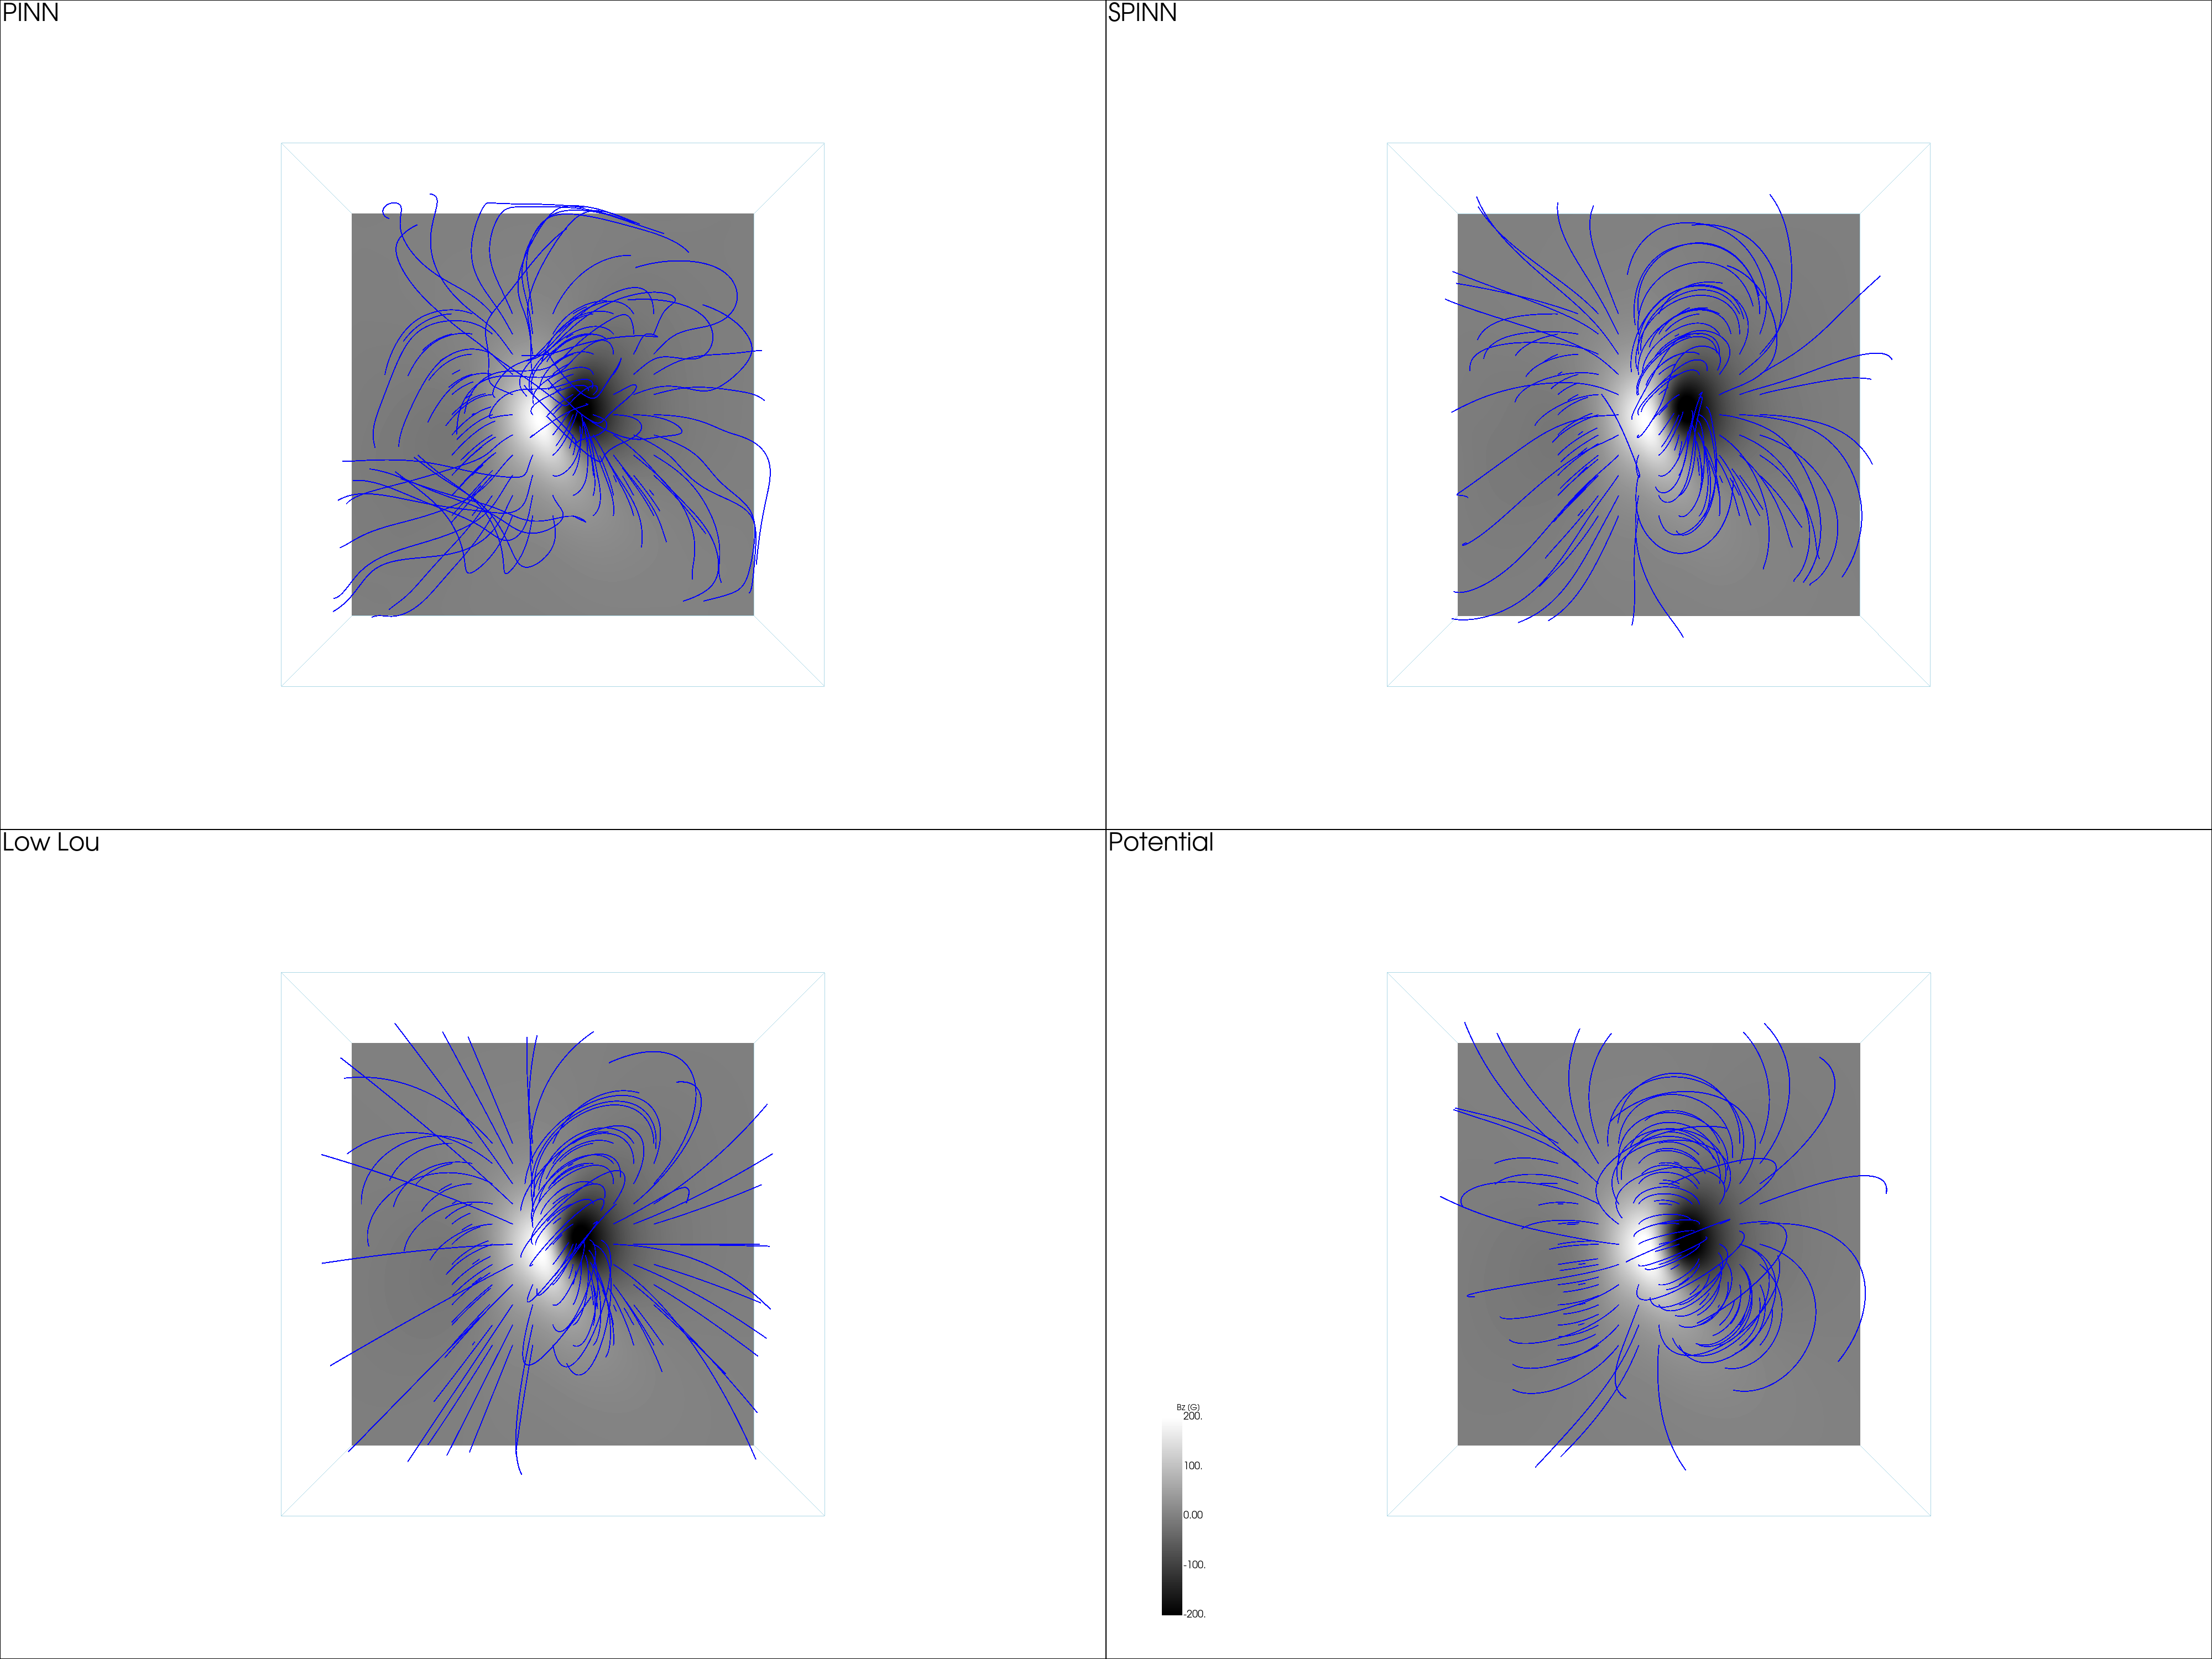

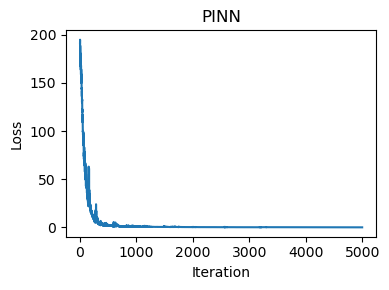

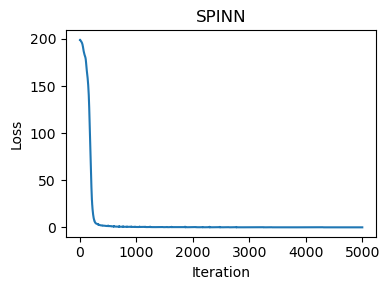

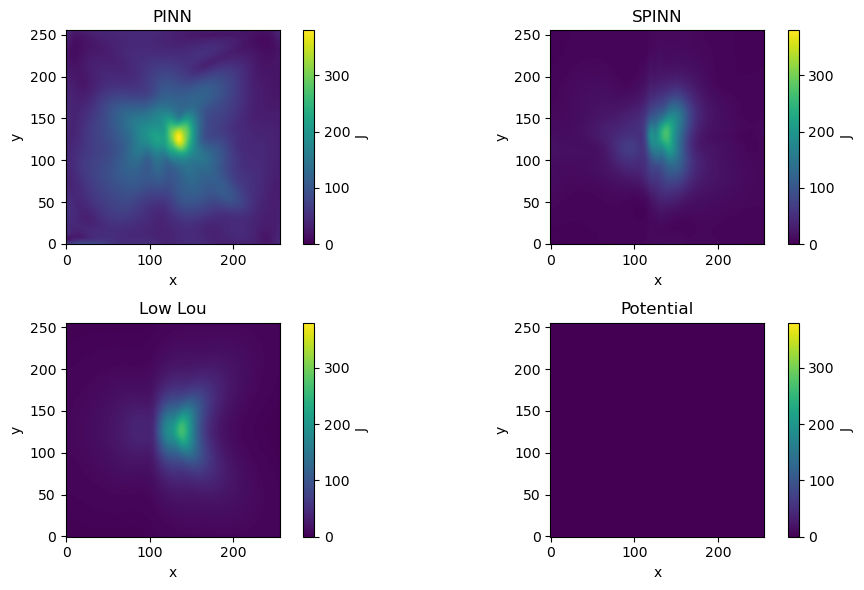

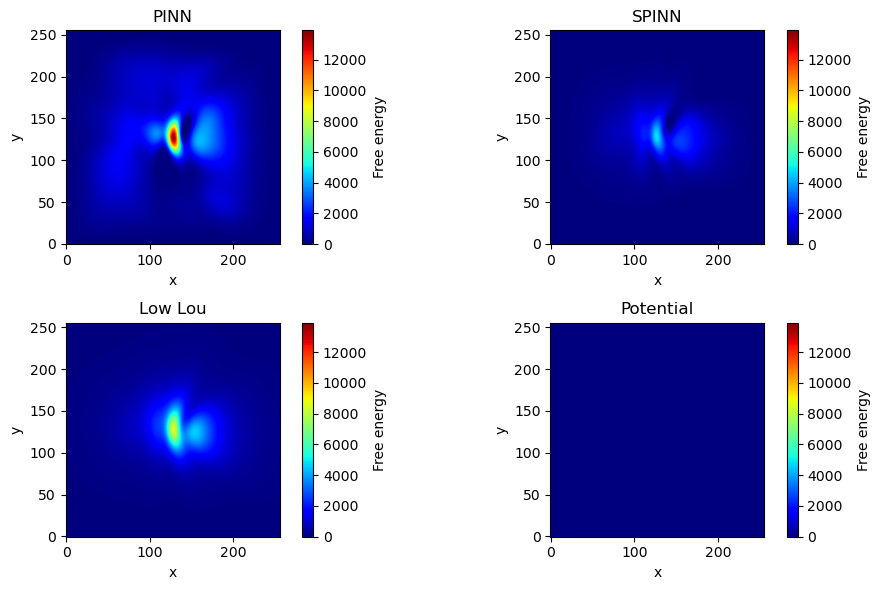

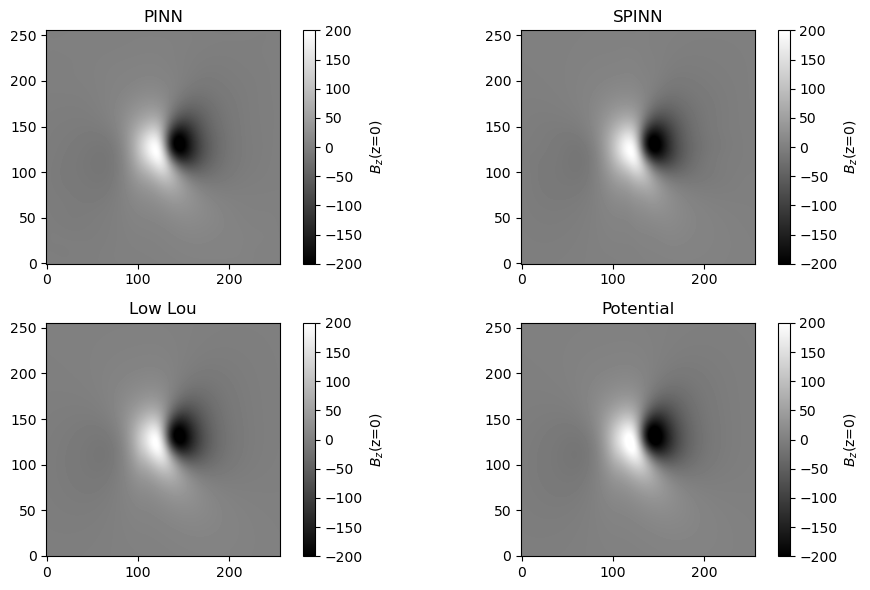

In [ ]:
configs = {}

Nz = 256
b_bottom_path = os.path.expanduser('~/workspace/_data/lowlou_256_256_256/b_bottom/b_bottom.npy')

output_direc = os.path.join(Path(b_bottom_path).parent.parent, 'lowlou')
moving(output_direc, pinn=False)

configs['All'] = {'Nz':Nz, 'b_bottom_path':b_bottom_path}

# Potential #############################
create_potential_field(b_bottom_path, Nz, batch_size=5000)
import torch 
torch.cuda.empty_cache() 

# PINN ##################################
spatial_norm = 32
b_norm = 100
total_iterations = 5000
log_interval = 1000

num_neurons = 256
w_ff = 1
w_div = 1
decay_iterations = 25000

Nc = 32
bc_batch_size = 10000
num_worker = 2

pinn_trainer = easyPINN(b_bottom_path, Nz)
pinn_trainer.train(spatial_norm, b_norm, num_neurons, w_ff, w_div, decay_iterations, total_iterations, log_interval, Nc, bc_batch_size, num_worker)
pinn_trainer.loss()
pinn_trainer.vtk()

configs['PINN'] = {'spatial_norm':spatial_norm, 
                   'b_norm':b_norm,
                   'num_neurons':num_neurons,
                   'w_ff':w_ff,
                   'w_div':w_div,
                   'decay_iterations':decay_iterations,
                   'total_iterations':total_iterations,
                   'log_interval':log_interval,
                   'Nc':Nc,
                   'bc_batch_size':bc_batch_size,
                   'num_worker':num_worker}

# SPINN #################################
b_norm = 100
total_iterations = 5000
log_interval = 1000
loss_threshold = 1e-4

with open(b_bottom_path, 'rb') as f:
    b_bottom = np.load(f)

Nx, Ny, _ = b_bottom.shape
features = 128
n_layers = 3
feat_sizes = tuple([features for _ in range(n_layers)]) 
r = 1024
out_dim = 3 
lr = 5e-4

pos_enc = 0
mlp = 'modified_mlp'
n_max_x = (Nx/Nx)
n_max_y = (Ny/Nx)
n_max_z = (Nz/Nx)
w_ff = 0.1
w_div = 0.1

w_bc = 1000
w_bc_decay_iterations = 25000

is_random = False
Nc = 32
random_interval = 1

parameters = {'feat_sizes' : feat_sizes, 
    'r' : r, 
    'out_dim' : out_dim, 
    'Nx' : Nx, 
    'Ny' : Ny, 
    'Nz' : Nz, 
    'b_norm' : b_norm,
    'pos_enc' : pos_enc,
    'mlp' : mlp,
    'lr': lr,
    'n_max_x': n_max_x,
    'n_max_y': n_max_y,
    'n_max_z': n_max_z,
    'is_random':is_random,
    'Nc':Nc,
    'random_interval':random_interval,
    'w_ff': w_ff,
    'w_div': w_div,
    'w_bc': w_bc,
    'w_bc_decay_iterations': w_bc_decay_iterations}

spinn = easySPINN(b_bottom_path, Nz)
spinn.train(b_norm, total_iterations, log_interval, loss_threshold, parameters)
spinn.loss()
spinn.vtk()

configs['SPINN'] = {'b_norm':b_norm,
                    'total_iterations':total_iterations,
                    'log_interval':log_interval,
                    'loss_threshold':loss_threshold,
                    'features' : features,
                    'n_layers': n_layers}
configs['SPINN'].update(parameters)

# Viz ###################################
vmin = -200
vmax = 200
i_siz = 128
j_siz = 128
i_res = 10
j_res = 10

viz = evaluator(b_bottom_path, Nz, lowlou=True)
viz.evaluation()
viz.Bz_plot(vmin, vmax, z=0)
viz.field_line(vmin, vmax, i_siz, j_siz, i_res, j_res)

configs['Viz'] = {'vmin':vmin,
                  'vmax':vmax,
                  'i_siz':i_siz,
                  'j_siz':j_siz,
                  'i_res':i_res,
                  'j_res':j_res}

import json 
from pathlib import Path
with open(os.path.join(output_direc, 'config.json'), 'w') as f:
    json.dump(configs, f, indent=4)

### HMI (single)

Exist /userhome/jeon_mg/workspace/_data/NOAA12673/20170906_083600/Potential/b_pot.vtk
Exist /userhome/jeon_mg/workspace/_data/NOAA12673/20170906_083600/PINN/model_final.pt
Exist /userhome/jeon_mg/workspace/_data/NOAA12673/20170906_083600/PINN/B_pinn_final.vtk


Potential Boundary: 100%|██████████| 380/380 [00:13<00:00, 27.59it/s]
{'feat_sizes': (128, 128, 128), 'r': 1024, 'out_dim': 3, 'Nx': 344, 'Ny': 224, 'Nz': 160, 'b_norm': 2500, 'pos_enc': 0, 'mlp': 'modified_mlp', 'lr': 0.0005, 'n_max_x': 2.15, 'n_max_y': 1.4, 'n_max_z': 1.0, 'is_random': True, 'Nc': None, 'random_interval': 1, 'w_ff': 1, 'w_div': 1, 'w_bc': 1000, 'w_bc_decay_iterations': 25000, 'Ncx': 114, 'Ncy': 74, 'Ncz': 53}
Complie Start
Complie End --> total: 40.16sec
100%|██████████| 5000/5000 [02:03<00:00, 40.44it/s]
Runtime --> total: 123.67sec (24.74ms/iter.)
Runtime: 163.83 sec
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fi

Saved /userhome/jeon_mg/workspace/_data/NOAA12673/20170906_083600/SPINN/B_spinn_final.vtk


  iteration  C_vec  C_cs  1-En  1-Em  eps     eps_p     sig_J         L1        L2  curlB
0      PINN    1.0   1.0   1.0   1.0  1.0  1.460602  0.620877  11.940352  7.053332    1.0
  iteration  C_vec  C_cs  1-En  1-Em  eps     eps_p     sig_J          L1          L2  curlB
0     SPINN    1.0   1.0   1.0   1.0  1.0  0.314998  0.800187  592.908203  621.734497    1.0
   iteration  C_vec  C_cs  1-En  1-Em  eps  eps_p     sig_J            L1        L2  curlB
0  Potential    1.0   1.0   1.0   1.0  1.0    1.0  0.807704  2.852597e-10  9.190876    1.0
    iteration     C_vec      C_cs     1-En      1-Em       eps     eps_p     sig_J          L1          L2     curlB
0  SPINN/PINN  0.588352  0.301128  0.12843  0.040988  0.215663  0.314998  0.800187  592.908203  621.734497  0.775096
    iteration     C_vec      C_cs      1-En      1-Em       eps     eps_p     sig_J         L1        L2     curlB
0  PINN/SPINN  0.588352  0.301128 -1.171175 -2.397407  4.636857  1.460602  0.620877  11.940352  7.05333

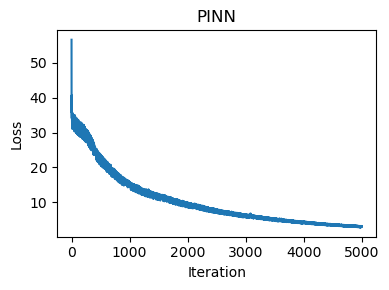

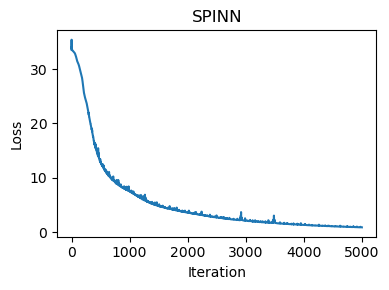

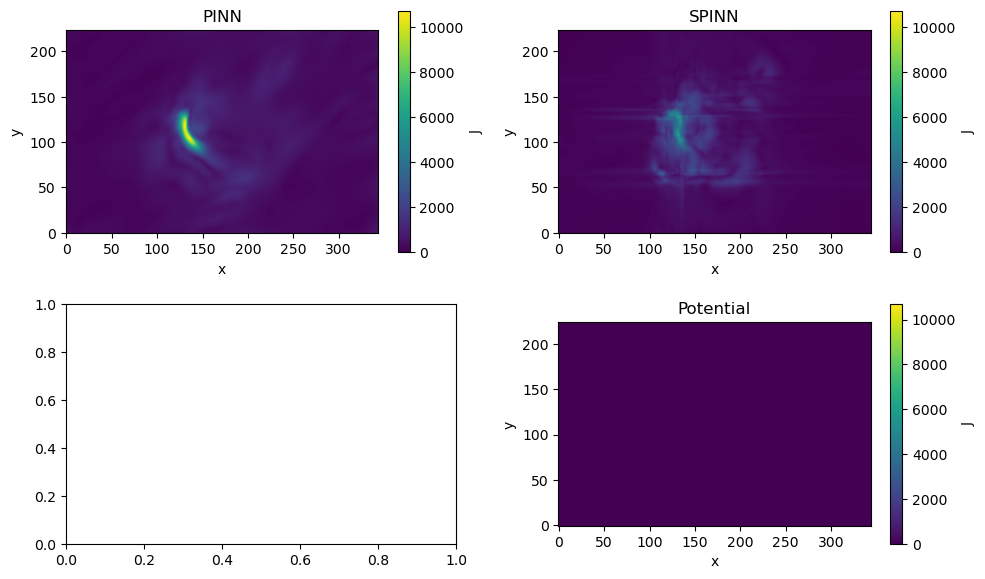

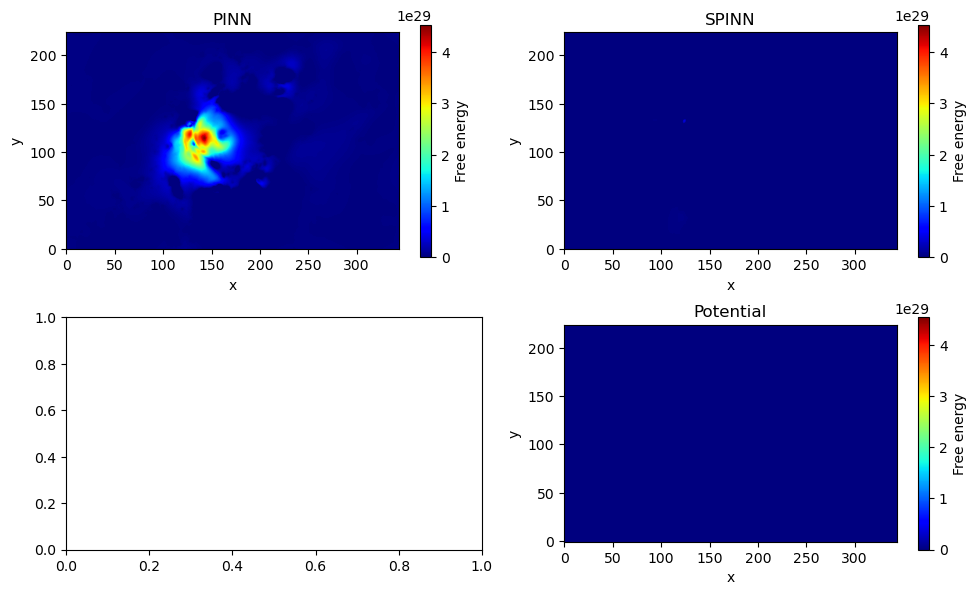

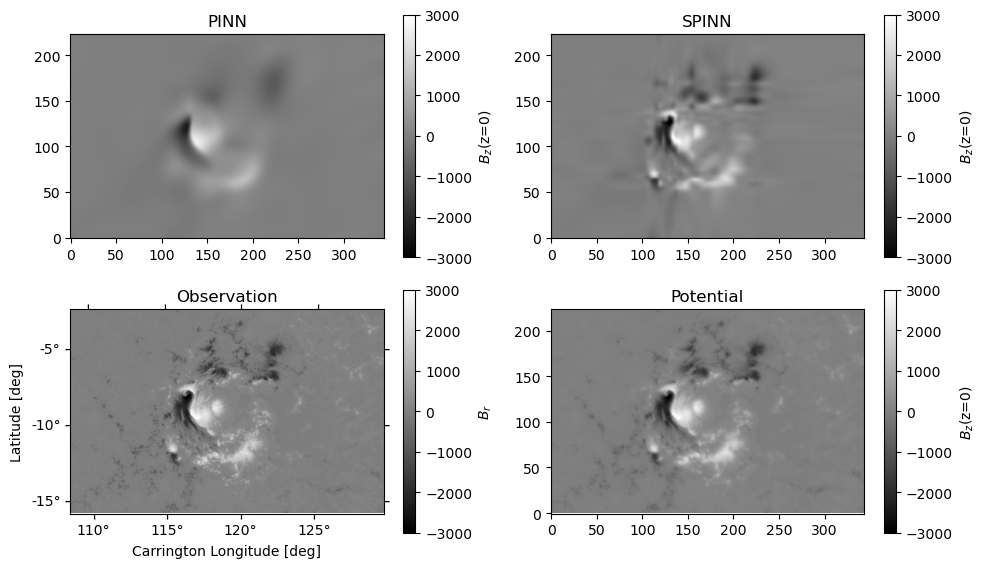

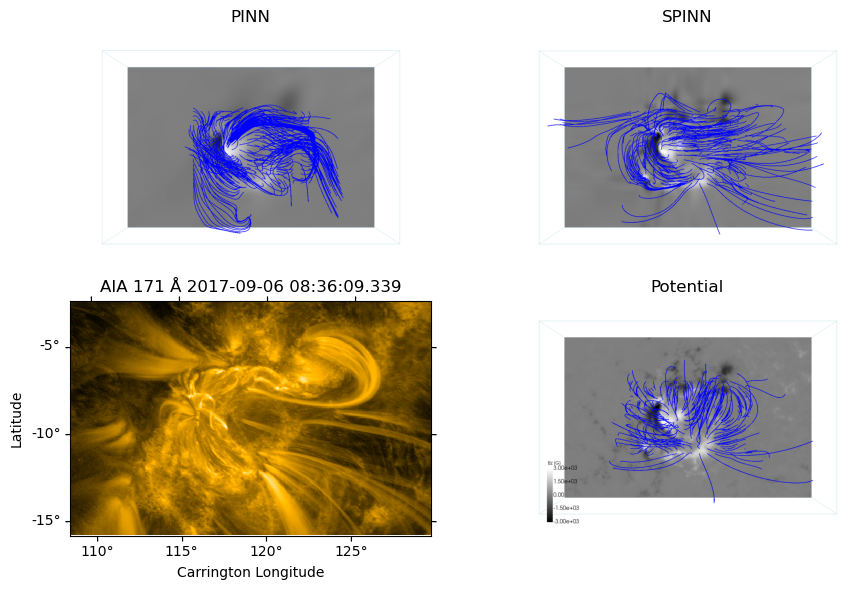

In [ ]:
configs = {}

Nz = 160
b_bottom_path = os.path.expanduser('~/workspace/_data/NOAA12673/b_bottom/b_bottom_20170906_083600.npy')

b_bottom_date = os.path.basename(b_bottom_path)[9:-4]
output_direc = os.path.join(Path(b_bottom_path).parent.parent, b_bottom_date)
moving(output_direc, pinn=False)

configs['All'] = {'Nz':Nz, 'b_bottom_path':b_bottom_path}

# Potential #############################
create_potential_field(b_bottom_path, Nz, batch_size=5000)
import torch 
torch.cuda.empty_cache() 

# PINN ##################################
spatial_norm = 160
b_norm = 2500
total_iterations = 5000
log_interval = 1000

num_neurons = 256
w_ff = 1
w_div = 1
decay_iterations = 25000

Nc = 32
bc_batch_size = 10000
num_worker = 2

pinn_trainer = easyPINN(b_bottom_path, Nz)
pinn_trainer.train(spatial_norm, b_norm, num_neurons, w_ff, w_div, decay_iterations, total_iterations, log_interval, Nc, bc_batch_size, num_worker)
pinn_trainer.loss()
pinn_trainer.vtk()

configs['PINN'] = {'spatial_norm':spatial_norm, 
                   'b_norm':b_norm,
                   'num_neurons':num_neurons,
                   'w_ff':w_ff,
                   'w_div':w_div,
                   'decay_iterations':decay_iterations,
                   'total_iterations':total_iterations,
                   'log_interval':log_interval,
                   'Nc':Nc,
                   'bc_batch_size':bc_batch_size,
                   'num_worker':num_worker}

# SPINN #################################
b_norm = 2500
total_iterations = 5000
log_interval = 1000
loss_threshold = 1e-3

with open(b_bottom_path, 'rb') as f:
    b_bottom = np.load(f)

Nx, Ny, _ = b_bottom.shape
features = 128
n_layers = 3
feat_sizes = tuple([features for _ in range(n_layers)]) 
r = 1024
out_dim = 3 
lr = 5e-4

pos_enc = 0
mlp = 'modified_mlp'
n_max_x = (Nx/Nz)
n_max_y = (Ny/Nz)
n_max_z = (Nz/Nz)
w_ff = 1
w_div = 1

w_bc = 1000
w_bc_decay_iterations = 25000

is_random = True
Nc = None
random_interval = 1
Ncx = Nx // 3
Ncy = Ny // 3
Ncz = Nz // 3

parameters = {'feat_sizes' : feat_sizes, 
    'r' : r, 
    'out_dim' : out_dim, 
    'Nx' : Nx, 
    'Ny' : Ny, 
    'Nz' : Nz, 
    'b_norm' : b_norm,
    'pos_enc' : pos_enc,
    'mlp' : mlp,
    'lr': lr,
    'n_max_x': n_max_x,
    'n_max_y': n_max_y,
    'n_max_z': n_max_z,
    'is_random':is_random,
    'Nc':Nc,
    'random_interval':random_interval,
    'w_ff': w_ff,
    'w_div': w_div,
    'w_bc': w_bc,
    'w_bc_decay_iterations': w_bc_decay_iterations,
    'Ncx': Ncx,
    'Ncy': Ncy,
    'Ncz': Ncz}

spinn = easySPINN(b_bottom_path, Nz)
spinn.train(b_norm, total_iterations, log_interval, loss_threshold, parameters)
spinn.loss()
spinn.vtk()

configs['SPINN'] = {'b_norm':b_norm,
                    'total_iterations':total_iterations,
                    'log_interval':log_interval,
                    'loss_threshold':loss_threshold,
                    'features' : features,
                    'n_layers': n_layers}
configs['SPINN'].update(parameters)

# Viz ###################################
vmin = -3000
vmax = 3000
i_siz = 160
j_siz = 100
i_res = 15
j_res = 15

stride = 2

obsdata = '/mnt/obsdata/sdo_AR/'
hmi_path = os.path.join(obsdata, 'NOAA12673_HARP7115/hmi/hmi.sharp_cea_720s.7115.20170906_083600_TAI.Br.fits')
aia_path = os.path.join(obsdata, 'NOAA12673_HARP7115/aia/171/aia.lev1_euv_12s.2017-09-06T083610Z.171.image_lev1.fits')

viz = evaluator(b_bottom_path, Nz, lowlou=False, stride=stride, hmi_path=hmi_path, aia_path=aia_path, wavelength=171)
viz.evaluation()
viz.Bz_plot(vmin, vmax, z=0)
viz.field_line(vmin, vmax, i_siz, j_siz, i_res, j_res, zoom=1.5)

configs['Viz'] = {'vmin':vmin,
                  'vmax':vmax,
                  'i_siz':i_siz,
                  'j_siz':j_siz,
                  'i_res':i_res,
                  'j_res':j_res,
                  'stride':stride}

import json 
from pathlib import Path
with open(os.path.join(output_direc, 'config.json'), 'w') as f:
    json.dump(configs, f, indent=4)